In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [5]:
# Параметры отображения датафреймов:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 25)

In [6]:
# Параметры отображения графиков:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams.update({'font.size': 11})

# Загрузка и обработка исходных данных

In [7]:
# Ссылка на csv-файл с данными:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv'

In [8]:
# Исходный файл в заголовках столбцов таблицы содержит символы,
# которые некорректно считываются при парсинге.
# Составляем новый список заголовков и считываем из файла только данные:
cols = ['date', 'n_bikes', 'hour', 'temperature', 'humidity', 'windspeed', 'visibility',
        'dew_point_temp', 'solar_radiation', 'rainfall', 'snowfall', 'season', 'holiday', 'func_day']
data = pd.read_csv(url, skiprows=1, names=cols, parse_dates=['date'])

In [9]:
# Типы данных:
data.shape

(8760, 14)

In [10]:
data.dtypes

date               datetime64[ns]
n_bikes                     int64
hour                        int64
temperature               float64
humidity                    int64
windspeed                 float64
visibility                  int64
dew_point_temp            float64
solar_radiation           float64
rainfall                  float64
snowfall                  float64
season                     object
holiday                    object
func_day                   object
dtype: object

In [11]:
data.head()

,date,n_bikes,hour,temperature,humidity,windspeed,visibility,dew_point_temp,solar_radiation,rainfall,snowfall,season,holiday,func_day
0,2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,2017-01-12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [12]:
data.isna().sum()

date               0
n_bikes            0
hour               0
temperature        0
humidity           0
windspeed          0
visibility         0
dew_point_temp     0
solar_radiation    0
rainfall           0
snowfall           0
season             0
holiday            0
func_day           0
dtype: int64

In [13]:
# Добавляем столбец с номером месяца:
data['month'] = data['date'].dt.month

In [14]:
# Добавляем столбец с номером года:
data['year'] = data['date'].dt.year

In [15]:
# Сводные ежедневные данные:
daily_data = data.groupby('date')['n_bikes'].sum().reset_index()

In [16]:
# Сводные данные по времени суток:
hourly_average = data.groupby('hour')['n_bikes'].mean().reset_index()

In [17]:
# Сводные данные по времени суток:
monthly_average = data.groupby('month')['n_bikes'].sum().reset_index()

In [18]:
# Сводные данные по сезонам:
seasonal_data = data.groupby('season')['n_bikes'].sum().reset_index()

# Визуализация данных

Text(0.5, 1.0, 'Спрос на аренду велосипедов')

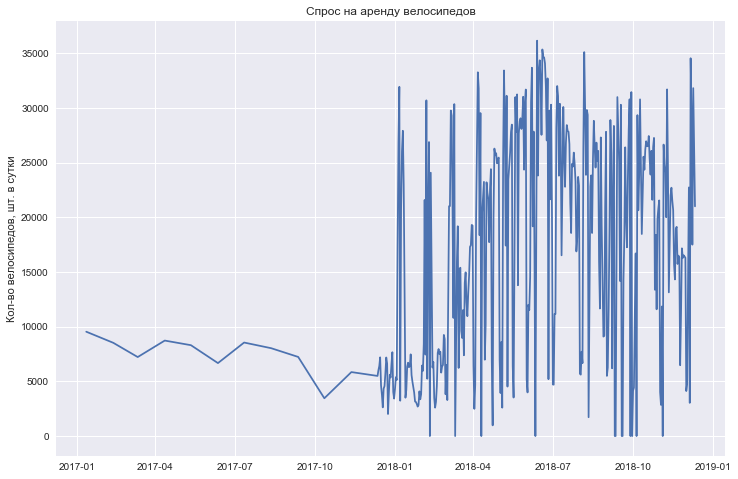

In [19]:
plt.plot(daily_data['date'], daily_data['n_bikes'])
plt.ylabel('Кол-во велосипедов, шт. в сутки')
plt.title('Спрос на аренду велосипедов')

Text(0.5, 1.0, 'Спрос на аренду велосипедов')

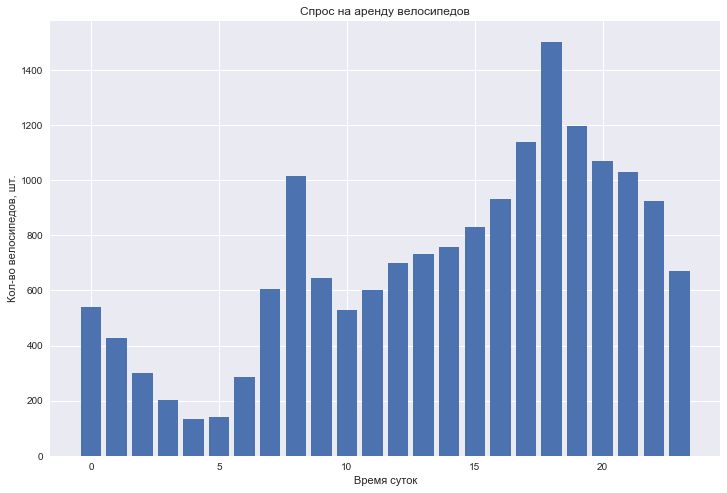

In [20]:
plt.bar(hourly_average['hour'], hourly_average['n_bikes'])
plt.xlabel('Время суток')
plt.ylabel('Кол-во велосипедов, шт.')
plt.title('Спрос на аренду велосипедов')

Text(0.5, 1.0, 'Спрос на аренду велосипедов')

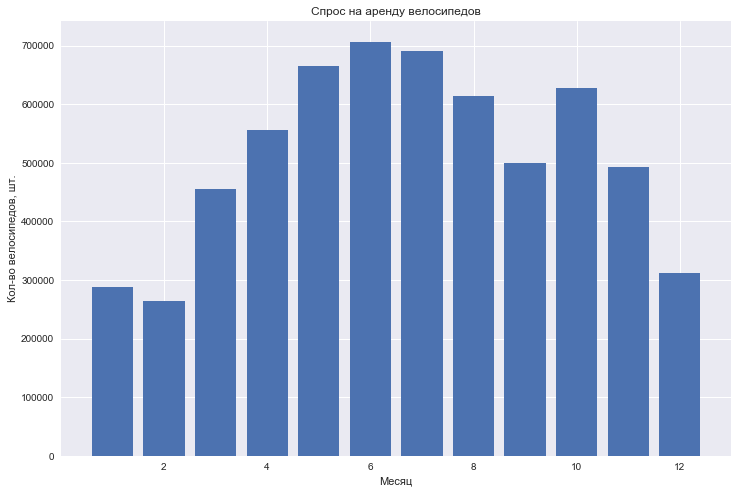

In [21]:
plt.bar(monthly_average['month'], monthly_average['n_bikes'])
plt.xlabel('Месяц')
plt.ylabel('Кол-во велосипедов, шт.')
plt.title('Спрос на аренду велосипедов')

Text(0.5, 1.0, 'Спрос на аренду велосипедов')

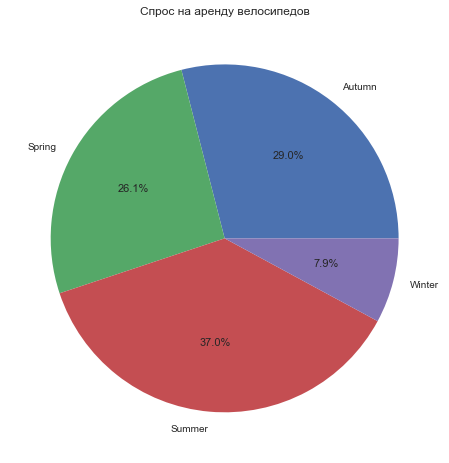

In [22]:
plt.pie(seasonal_data['n_bikes'], labels=seasonal_data['season'], autopct='%1.1f%%')
plt.title('Спрос на аренду велосипедов')

Text(0.5, 1, 'Матрица корреляции')

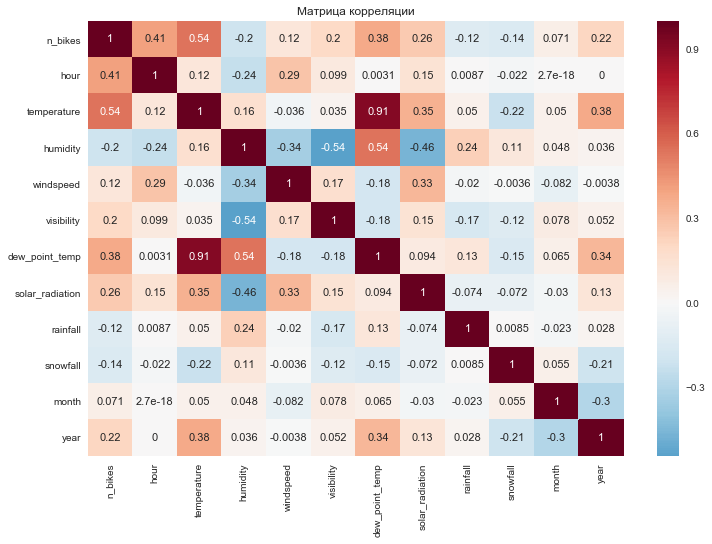

In [23]:
correlation = data.corr()
ax = sns.heatmap(correlation, center=0, annot=True, cmap='RdBu_r')
l, r = ax.get_ylim()
ax.set_ylim(l + 0.5, r - 0.5)
plt.yticks(rotation=0)
plt.title('Матрица корреляции')

#### Параметры с наиболее высокой корреляцией со спросом на аренду велосипедов:
- Температура воздуха
- Час суток
- Температура "точки росы"
- Солнечная радиация

Text(0.5, 0.98, 'Распределение значений параметров')

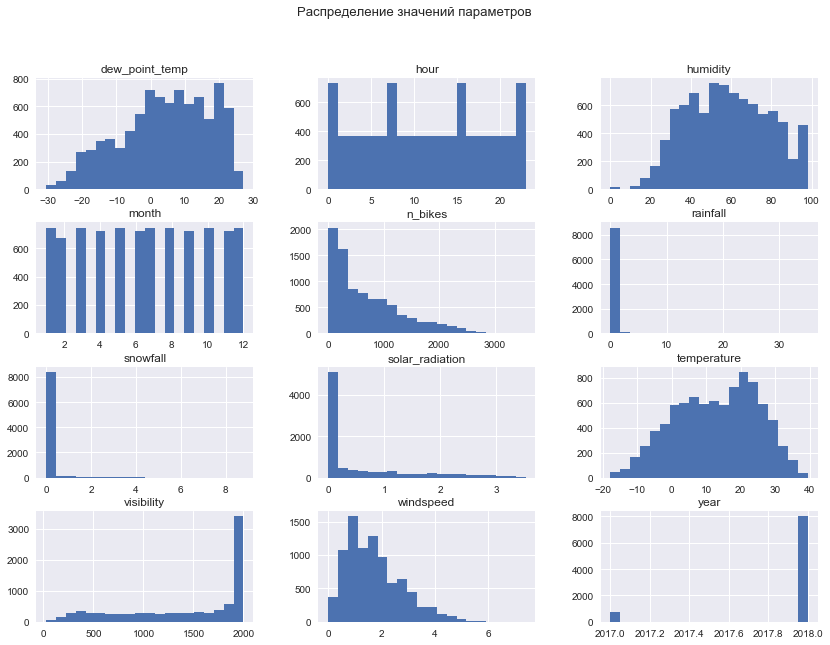

In [24]:
data.hist(bins=20, figsize=(14, 10));
plt.suptitle('Распределение значений параметров')

# Подготовка данных для модели

Из графика с динамикой числа аредованных велосипедов видно, что период до декабря 2017 года принципиально отличается по тренду и амплитуде колебаний рассматриваемого показателя от последующего периода. Для улучшения точности прогнозных моделей берем для обучения только данные с декабря 2017 года.

In [25]:
data = data[data['date'] > '2017-12']

In [26]:
# Прогнозируемые значения:
y = data['n_bikes']

In [27]:
# Входные параметры для моделей (все параметры датафрейма, начиная со столбца с часом суток):
X = data.loc[:, 'hour':]

In [28]:
# Составляем списки числовых и категорийных параметров:
num_cols = [col for col in X.columns if np.issubdtype(X.dtypes[col], np.number)]
cat_cols = [col for col in X.columns if col not in num_cols]

In [29]:
num_cols

['hour',
 'temperature',
 'humidity',
 'windspeed',
 'visibility',
 'dew_point_temp',
 'solar_radiation',
 'rainfall',
 'snowfall',
 'month',
 'year']

In [30]:
cat_cols

['season', 'holiday', 'func_day']

In [31]:
# Преобразование данных (кодирование категорийных столбцов,
# нормирование числовых значений):
ct = make_column_transformer(
    (OneHotEncoder(), cat_cols),
    (StandardScaler(), num_cols),
    remainder='passthrough')

In [32]:
# Нормирование данных:
X_processed = ct.fit_transform(X)

In [33]:
# Инструмент для разбиения данных на группы при кросс-валидации:
kf = KFold(10, shuffle=True)

In [34]:
# Список рассматриваемых моделей:
models = [('KNN', KNeighborsRegressor()),
          ('Decision Tree', DecisionTreeRegressor()),
          ('Gradient Boosting', GradientBoostingRegressor()),
          ('Random Forest', RandomForestRegressor(n_estimators=100))]

In [35]:
# Параметр R2 при кросс-валидации для рассматриваемых моделей:
for name, model in models:
    rmodel = model
    r2 = cross_val_score(rmodel, X_processed, y, cv=kf, scoring='r2').mean()
    print(f'{name}: R2 = {r2}')

KNN: R2 = 0.7951215146680686
Decision Tree: R2 = 0.7543400507959008
Gradient Boosting: R2 = 0.8449776361509447
Random Forest: R2 = 0.8782686270718914


#### Регрессоры с наиболее высокой точностью:
- Random Forest
- Gradient Boosting

In [36]:
# Создадим ансамбль из двух алгоритмов регрессии:
r_1 = RandomForestRegressor(n_estimators=100)
r_2 = GradientBoostingRegressor()
model = VotingRegressor([('RF', r_1), ('GB', r_2)])

In [37]:
# Точночть прогнозов при кросс-валидации:
cross_val_score(model, X_processed, y, cv=kf, scoring='r2').mean()

0.8735482896009149

Полученный результат сопоставим результатом модели Random Forest и не улучшил точность прогнозов.

Для улучшения модели целесообразно взять для обучения выборку данных за более продолжительный период времени (за несколько лет), чтобы сезонные колебания спроса и общий тренд учитывались более корректно. Однако в имеющемся датасете около половины от всех доступных данных не могут использоваться для анализа, т.к. принципиально отличаются по динамике от последующих значений.